In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import re

from scipy import stats

In [2]:
def find_number(text):
    num = re.findall(r'[0-9]+', text)
    return " ".join(num)

def has_cyrillic(text):
    return bool(re.search('[а-яА-Я]', text))

def find_min_salary(text):
    text = text.replace(u'\xa0', '')
    num = re.findall("от [0-9]*", text)
    try:
        return num[0].replace('от ', '')
    except:
        return ''

    
def get_salaries(df)->pd.DataFrame:
    """
    Extracts min and max salaries
    """
    df['max_salary'] = df['salary'].str.split('до').str[1]
    
    df['max_salary'] = np.where(df['max_salary'].isna(), '', df['max_salary'])
    df['max_salary'] = df['max_salary'].apply(lambda x: find_number(x))
    df['max_salary'] = df['max_salary'].str.replace(' ', '')
    
    df['min_salary'] = df['salary'].apply(lambda x: find_min_salary(x))
    
    for salary in ['max_salary', 'min_salary']:
        df[salary] = pd.to_numeric(df[salary])
        
    conds = [(df['max_salary']>0)&(df['min_salary']>0),
         (df['min_salary']>0),
         (df['max_salary']>0),
        ]
    choises = [(df['min_salary'] + df['max_salary'])/2, df['min_salary'], df['max_salary']]
    
    df['avg_salary'] = np.select(conds, choises)
    
    
    return df

In [16]:
def get_unique_skills(df)->set:
    """
    Extracts skils from df
    """
    unique_skils = set()
    for index, row in df.iterrows():

        skills_str = row['skills'].replace('[', '')
        skills_str = skills_str.replace(']', '')
        skills_str = skills_str.replace("'", '')
        list_skils = skills_str.split(', ')

        unique_skils.update(list_skils)
        
    return unique_skils


def create_skills_columns(df, unique_skils):
    """
    Add indicator columns 
    """
    for skill in unique_skils:
        try:
            df[skill] = np.where(df['skills'].str.contains(skill, regex=False), 1,0)
        except Exception as e:
            print(e)
            print(f'Cant create column {skill}')
        
    return df
    
def adjust_taxes(df):
    """
    Evaluates net salary 
    
    """
    for col in ['max_salary', 'min_salary', 'avg_salary']:
        df[col] = np.where(df['salary'].str.contains('до вычета налогов'),df[col]*0.87, df[col] )
        
    return df


In [17]:
df = pd.read_csv('some_data.csv')

In [18]:
df = get_salaries(df)
unique_skils = get_unique_skills(df)

In [19]:
df = create_skills_columns(df, unique_skils)

df = df[df['experience']!='0']
df = df[df['salary'].str.contains('руб')]
df = adjust_taxes(df)

In [20]:
df[df['experience']!='0'].to_csv('eda_hh_data_final.csv', index=False)

In [21]:
russian_skills = []
eng_skills = []
for skill in list(df.columns)[8:]:
    if not has_cyrillic(skill):
        eng_skills.append(skill)
    else:
        russian_skills.append(skill)


In [22]:
report = df[['experience', 'salary']].groupby('experience').agg('count')
report.columns = ['N vacancies']
report =report.reset_index()

## Наиболее востребованные специалисты по количеству лет опыта 

Text(0.5, 0, 'Количество ваканий')

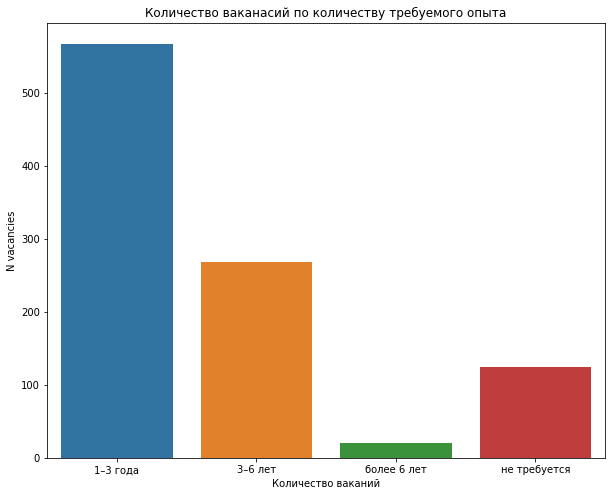

In [23]:
plt.figure(figsize=(10,8))
ax= sns.barplot(y='N vacancies', x='experience',
                data=report)
ax.set_title('Количество ваканасий по количеству требуемого опыта')
ax.set_xlabel('Количество ваканий')


Наблюдается наибольшая нехватка специалистов начального и среднего звена

## Как распределена зп? 

Text(0.5, 0, 'З/п в после налогов в руб.')

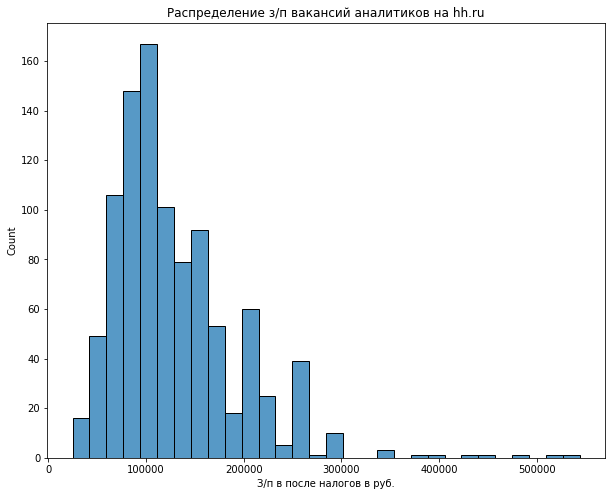

In [24]:
plt.figure(figsize=(10,8))
ax = sns.histplot(df['avg_salary'], bins=30)
ax.set_title('Распределение з/п вакансий аналитиков на hh.ru')
ax.set_xlabel('З/п в после налогов в руб.')


Наблюдаем не нормальное распределение с большим правым хвостом. Скорее всего, это вакансии опытных аналитиков или тимлидов.

Text(0.5, 0, 'З/п в после налогов в руб.')

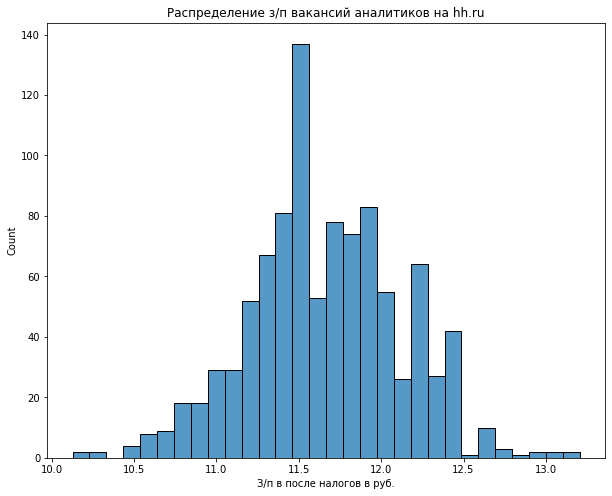

In [25]:
plt.figure(figsize=(10,8))
ax = sns.histplot(np.log(df['avg_salary']), bins=30)
ax.set_title('Распределение з/п вакансий аналитиков на hh.ru')
ax.set_xlabel('З/п в после налогов в руб.')


После сглаживания логарифмом наблюдаем распределение близкое к нормальному. Проверим нормальное ли оно? 

In [26]:
k2, p = stats.normaltest(np.log(df['avg_salary']))
p

0.8001884859183045

Р-value больше 0.05, следовательно, нельзя отвергнуть гипотезу о нормальности распределения логарифмированной выборки зарплат.

## Как опыт влияет на з/п? 

Text(0.5, 0, 'Опыт.')

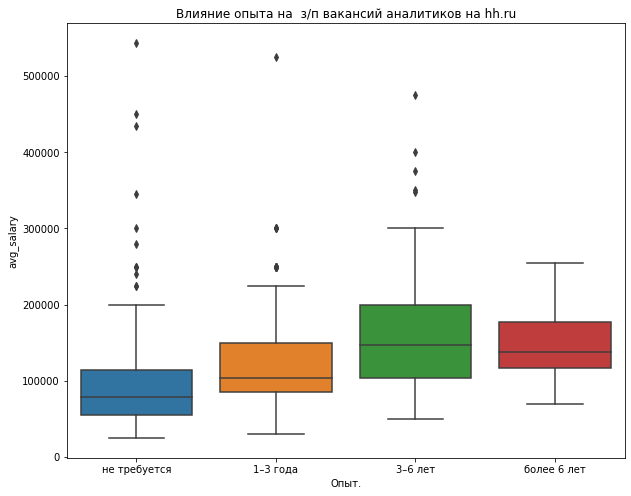

In [27]:
plt.figure(figsize=(10,8))
ax = sns.boxplot(y='avg_salary', x='experience', data=df.sort_values('avg_salary'))
ax.set_title('Влияние опыта на  з/п вакансий аналитиков на hh.ru')
ax.set_xlabel('Опыт.')


### Какие скилы необходимы для вакансий с требуемым опытом 6 лет +? 

In [28]:
six_years_skills = {
    'Name': [],
    'Count': []
}
for skill in russian_skills:
    count = len(df[(df['experience'] =='более 6 лет')&(df[skill]>0)])
    six_years_skills['Name'].append(skill)
    six_years_skills['Count'].append(count)
six_years_skills = pd.DataFrame(six_years_skills)


In [29]:
six_years_skills[six_years_skills['Count']>0].sort_values('Count', ascending=False).head(30)

,Name,Count
512,1С,4
507,аналитик,4
494,Управление проектами,4
416,Работа с большим объемом информации,3
100,1С: Управление предприятием,3
872,1С: Документооборот,3
484,Организаторские навыки,3
301,аналитика,3
126,Разработка технических заданий,3
898,Документооборот,3


Text(0.5, 0, 'Количество ваканий')

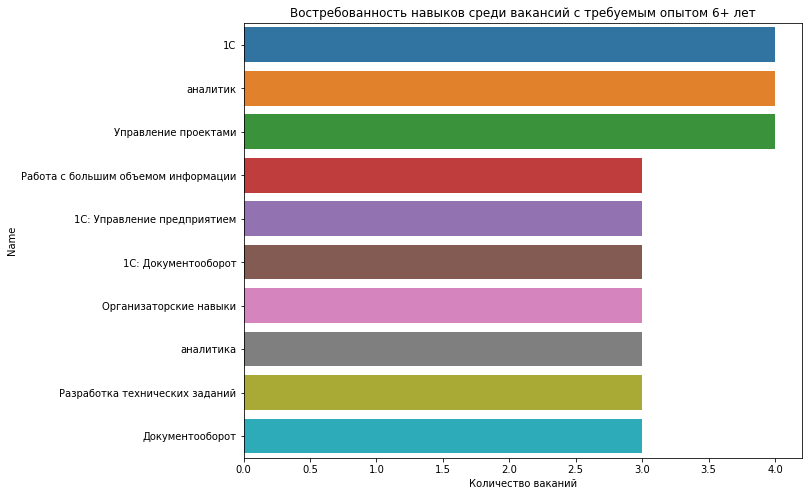

In [30]:
plt.figure(figsize=(10,8))
ax= sns.barplot(y='Name', x='Count',
                data=six_years_skills[six_years_skills['Count']>0].sort_values('Count', ascending=False).head(10))
ax.set_title('Востребованность навыков среди вакансий с требуемым опытом 6+ лет')
ax.set_xlabel('Количество ваканий')


Среди вакансий, которые требуют 6+ лет опыта, наблюдаем, что знания 1С- являются наиболее востребованными.

### Какие навыки/технологии более высокооплачиваемы: на русском или английском языках? 

In [31]:
report = {
    'skill':[],
    'type':[],
    'sum': []
}

In [32]:
for skill in list(df.columns)[8:]:
    report['skill'].append(skill)
    if not has_cyrillic(skill):
        report['type'].append('ENG')
    else:
        report['type'].append('RUS')
    report['sum'].append(df[df[skill]>0]['avg_salary'].mean())
report = pd.DataFrame(report)
report

,skill,type,sum
0,MS Power Builder,ENG,60017.500000
1,Яндекс.Маркет,RUS,100000.000000
2,Организация промо акций,RUS,95700.000000
3,MS Access,ENG,103018.888889
4,Технические средства информационной защиты,RUS,120000.000000
...,...,...,...
1236,Структурирование информации,RUS,60000.000000
1237,Управление ассортиментом,RUS,100000.000000
1238,Документооборот,RUS,121353.991250
1239,Учет остатков,RUS,109375.000000


Text(0.5, 0, 'Язык')

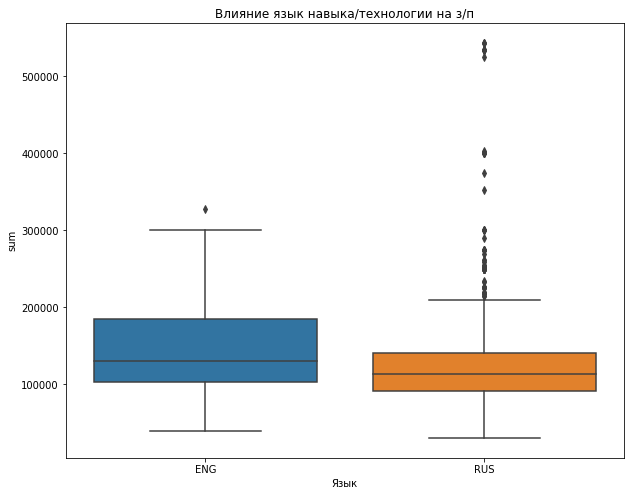

In [33]:
plt.figure(figsize=(10,8))
ax = sns.boxplot(y='sum', x='type', data=report)
ax.set_title('Влияние язык навыка/технологии на з/п')
ax.set_xlabel('Язык')

Наблюдаем, что медианное значение з/п с англоязычными навыками выше чем с русскоязычными, возможно потому что большинство технологий на английском языке. В то же время, среди русскоязычных вакансий наблюдается много выбросов с высокой з/п.

## Как количество навыков в вакансии влияют на з/п в вакансии? 

In [34]:
df['n_skills'] = df['skills'].str.count(',')+1

Text(0.5, 0, 'Количество навыков')

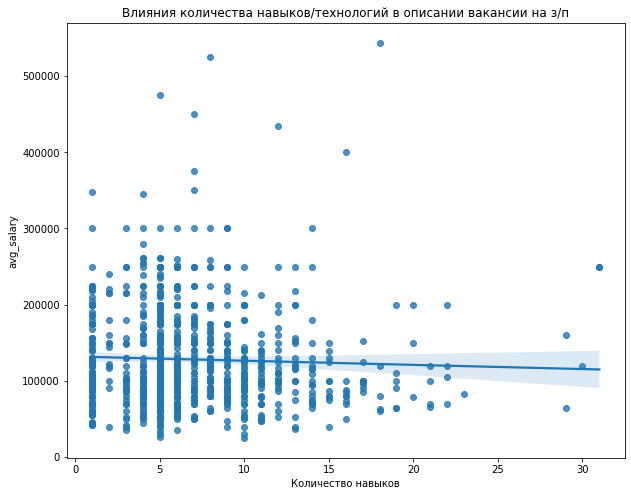

In [35]:
plt.figure(figsize=(10,8))
ax = sns.regplot(x = 'n_skills', y = 'avg_salary', data=df)
ax.set_title('Влияния количества навыков/технологий в описании вакансии на з/п')
ax.set_xlabel('Количество навыков')

Не наблюдаем влияния количества навыков в описании. 

## Как количество необходимых лет влияет на разброс в вилке з/п? 

In [36]:
df['range_salary'] = df['max_salary']-df['min_salary']

Text(0.5, 0, 'Опыт, лет')

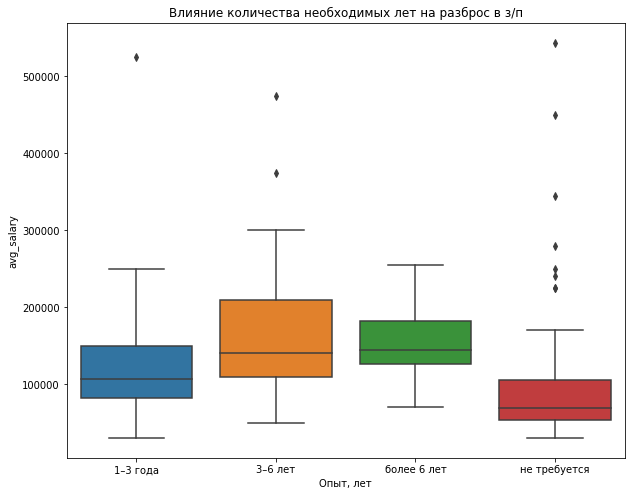

In [37]:
plt.figure(figsize=(10,8))
ax = sns.boxplot(y='avg_salary', x='experience', data=df[(df['max_salary']>0)
                                                         &(df['min_salary']>0)].sort_values('range_salary'))
ax.set_title('Влияние количества необходимых лет на разброс в з/п')
ax.set_xlabel('Опыт, лет')


В среднем медианный разброс по з/п минимальный в группе вакансий, где не требуется

In [51]:
df[eng_skills]

,MS Power Builder,MS Access,Machine Learning,mpstat,ITSM,IDEF0,TikTok,Youtube,ARIS,CMS Wordpress,...,ESG,Asana,E-Commerce,DFD,Atlassian Jira,Transact-SQL,Facebook Ads,OpenAPI,LM7,Oracle SQL Developer
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
993,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
sorted(eng_skills)[:200]

['1C',
 '1C ERP',
 '1C: ERP',
 'ABC analysis',
 'AI',
 'API',
 'ARIS',
 'ARPU',
 'ASO',
 'ATL',
 'Access',
 'Accounting',
 'Ad Hoc Analysis',
 'AdWords Editor',
 'Adobe',
 'Adobe Illustrator',
 'Adobe Lightroom',
 'Adobe Photoshop',
 'Agile',
 'Agile Project Management',
 'Airflow',
 'Amplitude',
 'Analysis',
 'Analytical Skills',
 'Analytical skills',
 'Anaplan',
 'Android',
 'Appsflyer',
 'ArcGIS',
 'ArchiMate',
 'Architecture',
 'Artificial Intelligence',
 'Asana',
 'Atlassian Confluence',
 'Atlassian Jira',
 'Axelot',
 'Axure RP',
 'Azure DevOps',
 'B2B Marketing',
 'BABOK',
 'BI',
 'BPMN',
 'BPMN 2.0',
 'BTL',
 'Balsamiq',
 'Best use',
 'Big Data',
 'BigQuery',
 'Bitrix',
 'Bitrix24',
 'Blockchain',
 'Bloomberg',
 'Bug Reporting',
 'Business Analysis',
 'Business Development',
 'Business English',
 'Business Intelligence Systems',
 'Business Planning',
 'Business Process improvement',
 'Business Studio',
 'Business intelligence',
 'C#',
 'C++',
 'C/C++',
 'C4 Model',
 'CJM',
 'CMS

In [54]:
#df = df.drop('0', axis=1)
#eng_skills.remove('0')
df[eng_skills].sum()

MS Power Builder         2
MS Access               27
Machine Learning         2
mpstat                   2
ITSM                     2
                        ..
Transact-SQL             3
Facebook Ads             6
OpenAPI                  1
LM7                      1
Oracle SQL Developer     1
Length: 339, dtype: int64

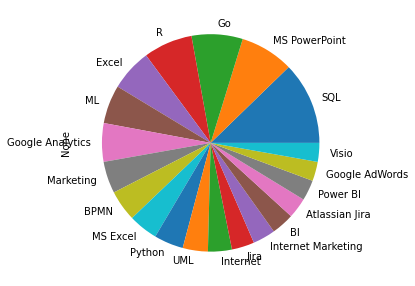

In [55]:
mf_skills = df[eng_skills].sum().sort_values(ascending=False)[:20]
mf_skills.plot.pie(figsize=(5, 5));

Рассмотрим самый популярный навык:

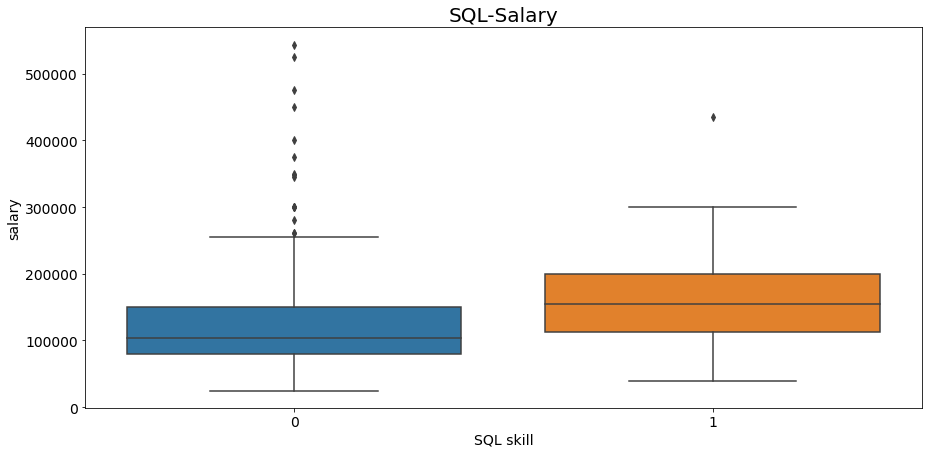

In [82]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='SQL', y='avg_salary', data=df)

plt.title('SQL-Salary', fontsize=20)
plt.ylabel('salary', fontsize=14)
plt.xlabel('SQL skill', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

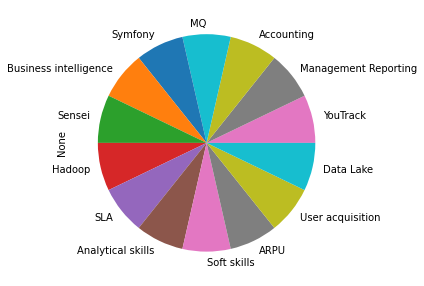

In [56]:
lf_skills = df[eng_skills].sum().sort_values(ascending=True)[:20]
lf_skills.plot.pie(figsize=(5, 5));

In [57]:
salaries_by_skills = {
    'Skill':[],
    'Min':[],
    'Max':[]
}
for skill in mf_skills.index:
    salaries_by_skills['Skill'].append(skill)
    salaries_by_skills['Min'].append(round(df[(df[skill] == 1)]['min_salary'].mean()))
    salaries_by_skills['Max'].append(round(df[(df[skill] == 1)]['max_salary'].mean()))

salaries_by_skills = pd.DataFrame(salaries_by_skills)
salaries_by_skills['Avg'] = salaries_by_skills[['Min', 'Max']].mean(axis=1)
salaries_by_skills

,Skill,Min,Max,Avg
0,SQL,140756,189336,165046.0
1,MS PowerPoint,92208,118300,105254.0
2,Go,91839,141146,116492.5
3,R,113227,167367,140297.0
4,Excel,92482,109295,100888.5
5,ML,141097,198283,169690.0
6,Google Analytics,94206,133197,113701.5
7,Marketing,86621,132496,109558.5
8,BPMN,138176,198205,168190.5
9,MS Excel,93158,106678,99918.0


Text(0.5, 0, 'Средняя зарплата')

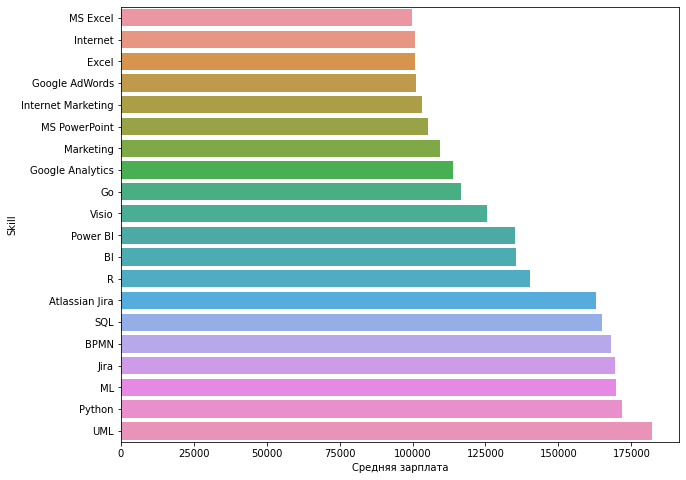

In [58]:
plt.figure(figsize=(10,8))
ax= sns.barplot(y='Skill', x='Avg',
                data=salaries_by_skills.sort_values('Avg'))
ax.set_xlabel('Средняя зарплата')

Выдвигаемые гипотезы:
- Количество лет опыта отрицательно  влияет на размер вилки з/п
- Количество лет опыта положительно на размер з/п
- Наиболее высокооплачиваемые специалисты те, которые владеют языками программирования.
- Количество навыков в зп увеличивает размер з/п
- Среди аналитиков с опытом 6+ больше будут востребованы менеджерские навыки

**попробуем позаниматься шаманской фигней**

In [59]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score,f1_score,log_loss,\
classification_report, roc_curve

import warnings
warnings.filterwarnings("ignore");

RAND = 10

In [60]:
print(f'Train size = {df.shape}')

Train size = (979, 1250)


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 979 entries, 0 to 996
Columns: 1250 entries, link to range_salary
dtypes: float64(4), int64(1242), object(4)
memory usage: 9.3+ MB


In [62]:
df

,link,skills,salary,experience,max_salary,min_salary,avg_salary,,MS Power Builder,Яндекс.Маркет,...,Общение,1C: Бухгалтерия,Контроль внедрения,Структурирование информации,Управление ассортиментом,Документооборот,Учет остатков,Экономика,n_skills,range_salary
0,https://hh.ru/vacancy/48176685?from=vacancy_se...,"['Scrum', 'Умение принимать решения', 'Ориента...",от 150 000 до 200 000 руб. на руки,1–3 года,200000.0,150000.0,175000.0,1,0,0,...,0,0,0,0,0,0,0,0,8,50000.0
1,https://hh.ru/vacancy/50056103?from=vacancy_se...,"['Power BI', 'Подготовка отчетов', 'MS Power B...",от 60 000 руб. на руки,1–3 года,NaN,60000.0,60000.0,1,0,0,...,0,0,0,0,0,0,0,0,5,NaN
2,https://hh.ru/vacancy/49881796?from=vacancy_se...,"['Английский\xa0— B1 — Средний', 'SQL', 'Англи...",от 170 000 до 210 000 руб. на руки,1–3 года,210000.0,170000.0,190000.0,1,0,0,...,0,0,0,0,0,0,0,0,12,40000.0
3,https://hh.ru/vacancy/49828501?from=vacancy_se...,"['Английский\xa0— B2 — Средне-продвинутый', 'S...",от 120 000 до 150 000 руб. на руки,1–3 года,150000.0,120000.0,135000.0,1,0,0,...,0,0,0,0,0,0,0,0,7,30000.0
4,https://hh.ru/vacancy/49893238?from=vacancy_se...,"['Английский\xa0— C1 — Продвинутый', 'SQL', 'B...",от 250 000 до 300 000 руб. до вычета налогов,3–6 лет,261000.0,217500.0,239250.0,1,0,0,...,0,0,0,0,0,0,0,0,4,43500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,https://hh.ru/vacancy/47394932?from=vacancy_se...,['Google Analytics Яндекс.Метрика Яндекс.Дирек...,от 110 000 до 140 000 руб. до вычета налогов,1–3 года,121800.0,95700.0,108750.0,1,0,0,...,0,0,0,0,0,0,0,0,1,26100.0
993,https://hh.ru/vacancy/49806538?from=vacancy_se...,"['Python', 'ООП', 'C++', 'Анализ данных', 'Mac...",от 250 000 до 250 000 руб. на руки,не требуется,250000.0,250000.0,250000.0,1,0,0,...,0,0,0,0,0,0,0,0,5,0.0
994,https://hh.ru/vacancy/49901475?from=vacancy_se...,"['Английский\xa0— A1 — Начальный', 'Грамотная ...",от 120 000 до 135 000 руб. на руки,3–6 лет,135000.0,120000.0,127500.0,1,0,0,...,0,0,0,0,0,0,0,0,7,15000.0
995,https://hh.ru/vacancy/49946451?from=vacancy_se...,"['Python', 'SQL', 'Power BI', 'Big Data', 'Ана...",от 160 000 руб. на руки,1–3 года,NaN,160000.0,160000.0,1,0,0,...,0,0,0,0,0,0,0,0,5,NaN


In [63]:
df.avg_salary.isna().sum() / df.shape[0]*100

0.0

In [64]:
df.nunique()

link               979
skills             870
salary             336
experience           4
max_salary          95
                  ... 
Документооборот      2
Учет остатков        2
Экономика            2
n_skills            26
range_salary        62
Length: 1250, dtype: int64

In [66]:
df.avg_salary.unique()

array([175000.  ,  60000.  , 190000.  , 135000.  , 239250.  , 125000.  ,
       130000.  , 200000.  , 220000.  , 156600.  , 250000.  , 225000.  ,
       300000.  , 100000.  , 104400.  ,  80000.  ,  87000.  , 150000.  ,
       215000.  , 345000.  , 130500.  ,  70000.  , 252300.  , 121800.  ,
       174000.  , 115000.  ,  95000.  , 165000.  , 160950.  , 182700.  ,
       110000.  , 180000.  , 120000.  ,  40000.  , 213150.  , 160000.  ,
       108750.  , 217500.  ,  95700.  ,  75000.  , 200100.  , 140000.  ,
        50000.  ,  37500.  ,  41500.  ,  79170.  , 104000.  , 260000.  ,
       185000.  ,  60900.  ,  65000.  , 155000.  ,  65250.  ,  34800.  ,
       147900.  ,  45000.  , 300150.  ,  90001.5 , 117450.  ,  90000.  ,
        85000.  ,  69600.  ,  70035.  ,  71775.  , 435000.  ,  78300.  ,
       191400.  , 113100.  ,  77500.  , 187050.  , 100050.  ,  66500.  ,
       111360.  , 195750.  , 170000.  ,  82650.  , 139200.  , 210000.  ,
       167475.  ,  91350.  , 100000.41, 152250.  , 

In [67]:
df.describe(include=object)

,link,skills,salary,experience
count,979,979,979,979
unique,979,870,336,4
top,https://hh.ru/vacancy/49843566?from=vacancy_se...,[],от 100 000 руб. на руки,1–3 года
freq,1,95,49,567


In [86]:
df.columns

Index(['link', 'skills', 'salary', 'experience', 'max_salary', 'min_salary',
       'avg_salary', '', 'MS Power Builder', 'Яндекс.Маркет',
       ...
       'Общение', '1C: Бухгалтерия', 'Контроль внедрения',
       'Структурирование информации', 'Управление ассортиментом',
       'Документооборот', 'Учет остатков', 'Экономика', 'n_skills',
       'range_salary'],
      dtype='object', length=1250)

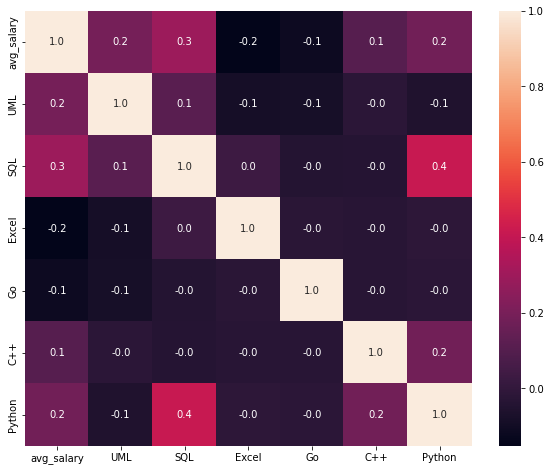

In [92]:
num_cols = ['avg_salary', 'UML', 'SQL', 'Excel', 'Go', 'C++', 'Python']

plt.figure(figsize=(10, 8))

sns.heatmap(df[num_cols].corr(method='spearman'), annot=True, fmt=".1f");

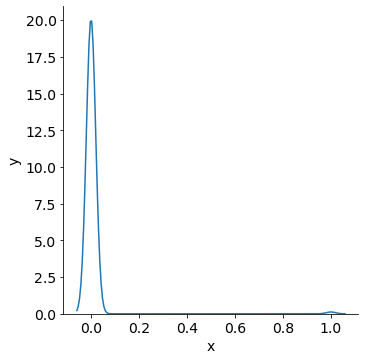

In [96]:
sns.displot(df, x='C++', kind="kde", common_norm=False)

plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

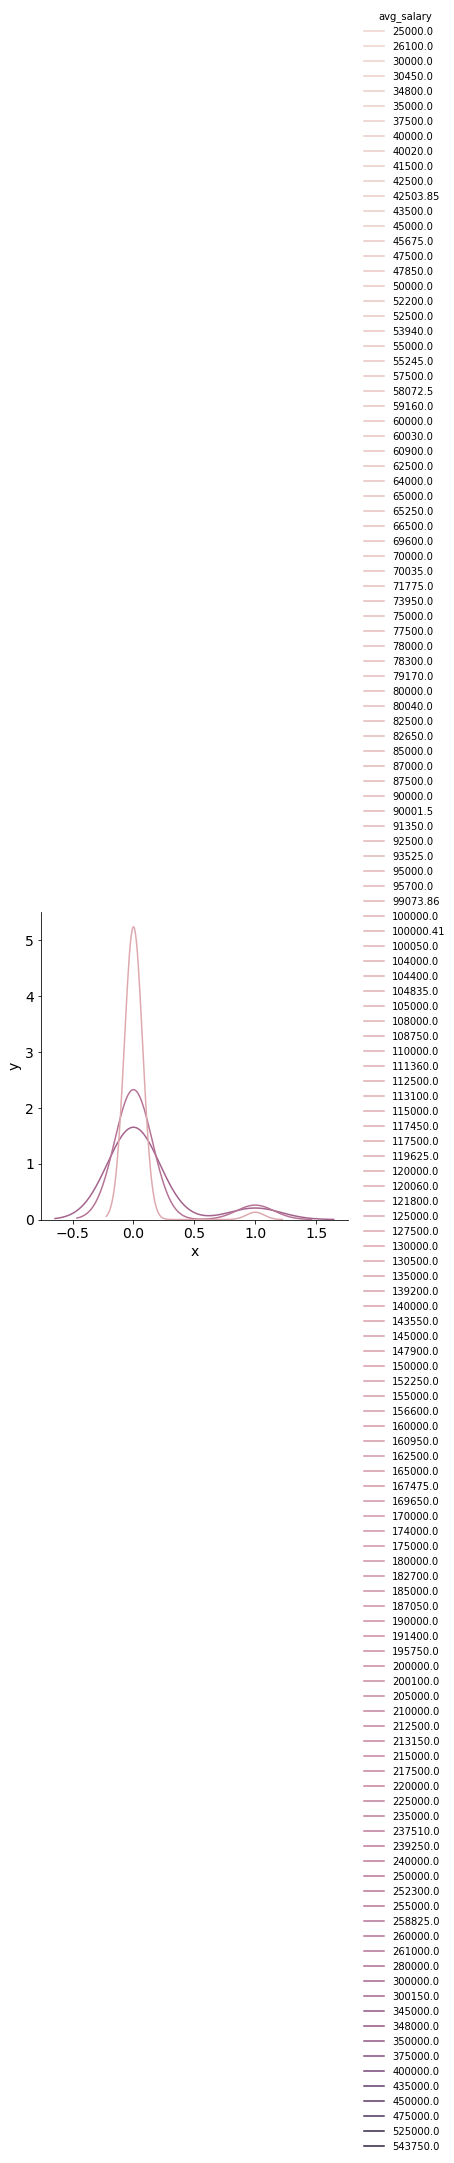

In [97]:
sns.displot(df, x='C++', hue='avg_salary', kind="kde", common_norm=False)

plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

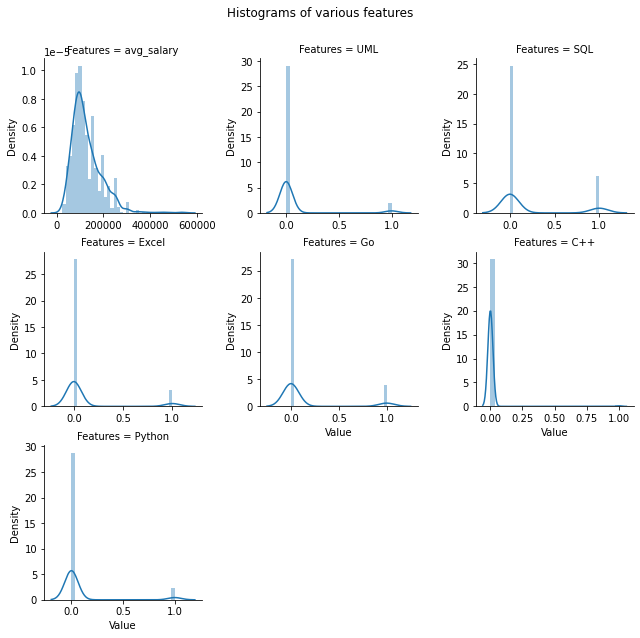

In [98]:
num_cols = ['avg_salary', 'UML', 'SQL', 'Excel', 'Go', 'C++', 'Python']

numeric_features = df[num_cols]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={"level_1": "Features", 0: "Value"})

ax = sns.FacetGrid(data=numeric_features, col="Features",
                  col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")

plt.subplots_adjust(top=0.9)
plt.suptitle("Histograms of various features");

In [101]:
cat_cols = ['avg_salary', 'UML', 'SQL', 'Excel', 'Go', 'C++', 'Python']
df_label = pd.get_dummies(df, columns=cat_cols,
                          drop_first=True).drop('link', axis=1)
df_label[:5]

,skills,salary,experience,max_salary,min_salary,,MS Power Builder,Яндекс.Маркет,Организация промо акций,MS Access,...,avg_salary_450000.0,avg_salary_475000.0,avg_salary_525000.0,avg_salary_543750.0,UML_1,SQL_1,Excel_1,Go_1,C++_1,Python_1
0,"['Scrum', 'Умение принимать решения', 'Ориента...",от 150 000 до 200 000 руб. на руки,1–3 года,200000.0,150000.0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,"['Power BI', 'Подготовка отчетов', 'MS Power B...",от 60 000 руб. на руки,1–3 года,NaN,60000.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"['Английский\xa0— B1 — Средний', 'SQL', 'Англи...",от 170 000 до 210 000 руб. на руки,1–3 года,210000.0,170000.0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
3,"['Английский\xa0— B2 — Средне-продвинутый', 'S...",от 120 000 до 150 000 руб. на руки,1–3 года,150000.0,120000.0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,"['Английский\xa0— C1 — Продвинутый', 'SQL', 'B...",от 250 000 до 300 000 руб. до вычета налогов,3–6 лет,261000.0,217500.0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
